In [103]:
%cd ~/data/reference/

/qbio/nest/minor/data/reference


In [9]:
#protein_coding transcript만 추출하기

import re

transcripts = [] #protein_coding transcript id의 list

with open ('gencode.vM25.primary_assembly.annotation.gtf') as inpfile:
    for line in inpfile:
        if line.startswith('#'):
            continue
        else:
            line = line.strip('\n')
            column = line.split('\t')
            types = column[2]
            if types == 'transcript':
                transcript_id = re.split('";|"',column[8])[3]
                gene_type = re.split('";|"',column[8])[5]
                if gene_type == 'protein_coding':
                    if transcript_id in transcripts:
                        continue
                    else:
                        transcripts.append(transcript_id)

In [10]:
#longest isoform
transcript_isoforms = {}
longest_isoform = []

with open ('gencode.vM25.primary_assembly.annotation.gtf') as inpfile:
    for line in inpfile:
        if line.startswith('#'):
            continue
        else:
            line = line.strip('\n')
            column = line.split('\t')
            if column[2] == 'transcript':
                length = abs(int(column[4]) - int(column[3]))
                ids = re.split('";|"',column[8])
                gene_id = ids[1]
                transcript_id = ids[3]
                if transcript_id in transcripts:
                    if gene_id in transcript_isoforms:
                        transcript_isoforms[gene_id].append([transcript_id, length])
                    else:
                        transcript_isoforms[gene_id] = [[transcript_id, length]]
                    
for gene in transcript_isoforms: #longest isoform만 남기기 
    lists = []
    for transcript in transcript_isoforms[gene]:#transcript = [transcript_id, length]
        lists.append(transcript[1])
    for transcript in transcript_isoforms[gene]:
        if transcript[1] == max(lists):
            longest_isoform.append(transcript[0])
            break #만약 2개 이상 isoform의 길이가 같다면 임의로 하나만 선택하도록

In [50]:
#transcript_info : transcript_id = [startcodon, stopcodon, CDS_length]

transcript_info = {}

with open ('gencode.vM25.primary_assembly.annotation.gtf') as inpfile:
    for line in inpfile:
        if line.startswith('#'):
            continue
        else:
            line = line.strip('\n')
            column = line.split('\t')
            types = column[2]
            if types == 'CDS':
                start = int(column[3])
                end = int(column[4])
                length = abs(start - end) + 1
                transcript_id = re.split('";|"',column[8])[3]
                strand = column[6]
                if transcript_id in longest_isoform:
                    if transcript_id in transcript_info:
                        if strand == '+':
                            if transcript_info[transcript_id][0] > start:
                                transcript_info[transcript_id][0] = start
                            if transcript_info[transcript_id][1] < end:
                                transcript_info[transcript_id][1] = end + 1
                            transcript_info[transcript_id][2] += length
                        else:
                            if transcript_info[transcript_id][0] < end:
                                transcript_info[transcript_id][0] = end
                            if transcript_info[transcript_id][1] > start:
                                transcript_info[transcript_id][1] = start - 1
                            transcript_info[transcript_id][2] += length
                    else:
                        if strand == '+':
                            transcript_info[transcript_id] = [start, end+1, length]
                        else:
                            transcript_info[transcript_id] = [end, start-1, length]

In [73]:
UTR = {} #5'UTR

with open ('gencode.vM25.primary_assembly.annotation.gtf') as inpfile:
    for line in inpfile:
        if line.startswith('#'):
            continue
        else:
            line = line.strip('\n')
            column = line.split('\t')
            types = column[2]
            if types == 'exon':
                start = int(column[3])
                end = int(column[4])
                length = abs(start-end) + 1
                transcript_id = re.split('";|"', column[8])[3]
                strand = column[6]
                if transcript_id in transcript_info:
                    startcodon = transcript_info[transcript_id][0]
                    stopcodon = transcript_info[transcript_id][1]
                    if transcript_id in UTR:
                        if strand == '+':
                            if end <= startcodon:
                                UTR[transcript_id] += length
                            if start <= startcodon and end > startcodon:
                                UTR[transcript_id] += (startcodon - start)
                        else:
                            if start >= startcodon:
                                UTR[transcript_id] += length
                            if start < startcodon and startcodon <= end:
                                UTR[transcript_id] += (end - startcodon)
                    else:
                        if strand == '+':
                            if end <= startcodon:
                                UTR[transcript_id] = length
                            if start <= startcodon and end > startcodon:
                                UTR[transcript_id] = (startcodon - start)
                        else:
                            if start >= startcodon:
                                UTR[transcript_id] = length
                            if start < startcodon and startcodon <= end:
                                UTR[transcript_id] = (end - startcodon)

In [74]:
#Refseq : transcript = [startcodon, stopcodon, 5'UTR, CDS_length, strand]

Refseq = {}

with open ('gencode.vM25.primary_assembly.annotation.gtf') as inpfile:
    for line in inpfile:
        if line.startswith('#'):
            continue
        else:
            line = line.strip('\n')
            column = line.split('\t')
            types = column[2]
            if types == 'transcript':
                transcript_id = re.split('";|"',column[8])[3]
                if transcript_id in transcript_info:
                    strand = column[6]
                    startcodon = transcript_info[transcript_id][0]
                    stopcodon = transcript_info[transcript_id][1]
                    CDS_length = transcript_info[transcript_id][2]
                    if transcript_id in UTR:
                        front_UTR = UTR[transcript_id]
                    else:
                        front_UTR = 0
                    Refseq[transcript_id] = [startcodon, stopcodon, front_UTR, CDS_length, strand]

In [110]:
%cd ~/outcome/outcome_alignment/SAMfiles/SAM_rimoved_4,16/

/qbio/nest/minor/outcome/outcome_alignment/SAMfiles/SAM_rimoved_4,16


In [127]:
#siLin28a single hit 구하기


siLin28a_alignments={} # Qname:[transcript_id, edit_distance, POS, strand]
siLin28a_single_hits = {} # alignments[Qname] 의 값 중 single_best hit만 > Qname별 하나씩
with open ('ribosomeprof_siLin28a_removed.sam') as inpfile:
    for line in inpfile:
        if line.startswith('@'): #header pass
            continue
        else:
            line = line.strip('\n')
            column = line.split('\t')
            transcript_id = column[2]
            Qname = column[0]
            POS = int(column[3]) 
            edit_distance = int(column[15].split(':')[2])#sam file의 nM값
            if Qname in siLin28a_alignments:
                siLin28a_alignments[Qname].append([transcript_id, edit_distance, POS, strand])
            else:
                siLin28a_alignments[Qname] = [[transcript_id, edit_distance, POS, strand]]
                    
for Qname in siLin28a_alignments:
    if len(siLin28a_alignments[Qname]) == 1 and siLin28a_alignments[Qname][0][1] <= 1:
        if siLin28a_alignments[Qname][0][0] in Refseq:#single alignment 된 경우&edit distancd<=1
            siLin28a_single_hits[Qname] = siLin28a_alignments[Qname][0]
    else:#multi align 된 경우
        lists = []#edit distance의 list
        for alings in siLin28a_alignments[Qname]:
            lists.append(alings[1])
        if lists.count(min(lists)) == 1 and min(lists) <= 1:
            for alings in siLin28a_alignments[Qname]:
                if alings[1] == min(lists) and alings[0] in Refseq:
                    siLin28a_single_hits[Qname] = alings
                    break

In [129]:
#siLuc single hit 구하기


siLuc_alignments={} # Qname:[transcript_id, edit_distance, POS, strand]
siLuc_single_hits = {} # alignments[Qname] 의 값 중 single_best hit만 > Qname별 하나씩
with open ('ribosomeprof_siLuc_removed.sam') as inpfile:
    for line in inpfile:
        if line.startswith('@'): #header pass
            continue
        else:
            line = line.strip('\n')
            column = line.split('\t')
            transcript_id = column[2]
            Qname = column[0]
            POS = int(column[3]) 
            edit_distance = int(column[15].split(':')[2])#sam file의 nM값
            if Qname in siLuc_alignments:
                siLuc_alignments[Qname].append([transcript_id, edit_distance, POS, strand])
            else:
                siLuc_alignments[Qname] = [[transcript_id, edit_distance, POS, strand]]
                    
for Qname in siLuc_alignments:
    if len(siLuc_alignments[Qname]) == 1 and siLuc_alignments[Qname][0][1] <= 1:
        if siLuc_alignments[Qname][0][0] in Refseq:#single alignment 된 경우&edit distancd<=1
            siLuc_single_hits[Qname] = siLuc_alignments[Qname][0]
    else:#multi align 된 경우
        lists = []#edit distance의 list
        for alings in siLuc_alignments[Qname]:
            lists.append(alings[1])
        if lists.count(min(lists)) == 1 and min(lists) <= 1:
            for alings in siLuc_alignments[Qname]:
                if alings[1] == min(lists) and alings[0] in Refseq:
                    siLuc_single_hits[Qname] = alings
                    break

In [138]:
siLin28a_ribosomeprof_start = []
siLin28a_ribosomeprof_stop = []
siLuc_ribosomeprof_start = []
siLuc_ribosomeprof_stop = []

for line in siLin28a_single_hits:
    #Refseq : transcript = [startcodon, stopcodon, 5'UTR, CDS_length, strand]
    #Qname:[transcript_id, edit_distance, POS, strand]
    POS = siLin28a_single_hits[line][2]
    transcript_id = siLin28a_single_hits[line][0]
    front_UTR = Refseq[transcript_id][2] #5'UTR
    CDS_length = Refseq[transcript_id][3]
    siLin28a_ribosomeprof_start.append(POS - front_UTR - 1)
    siLin28a_ribosomeprof_stop.append(-1*(CDS_length - POS + front_UTR))
    
for line in siLuc_single_hits:
    POS = siLuc_single_hits[line][2]
    transcript_id = siLuc_single_hits[line][0]
    front_UTR = Refseq[transcript_id][2]
    CDS_length = Refseq[transcript_id][3]
    siLuc_ribosomeprof_start.append(POS - front_UTR - 1)
    siLuc_ribosomeprof_stop.append(-1*(CDS_length - POS + front_UTR))
    

In [139]:
from collections import Counter

siLin28a_start = dict(Counter(siLin28a_ribosomeprof_start))
siLin28a_stop = dict(Counter(siLin28a_ribosomeprof_stop))
siLuc_start = dict(Counter(siLuc_ribosomeprof_start))
siLuc_stop = dict(Counter(siLuc_ribosomeprof_stop))

In [140]:
for line in siLin28a_stop:
    siLin28a_stop[line] = siLin28a_stop[line]/1000
    
for line in siLin28a_start:
    siLin28a_start[line] = siLin28a_start[line]/1000
    
for line in siLuc_start:
    siLuc_start[line] = siLuc_start[line]/1000
    
for line in siLuc_stop:
    siLuc_stop[line] = siLuc_stop[line]/1000

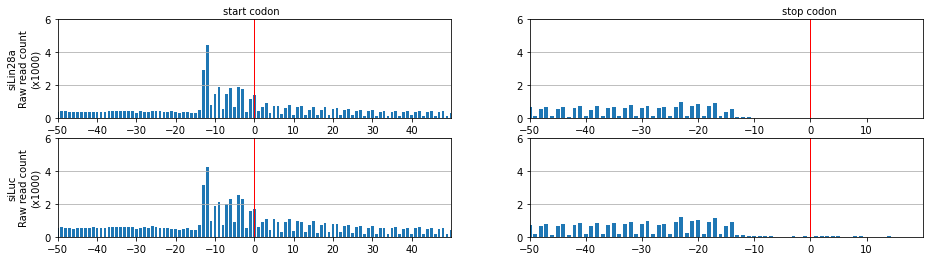

In [162]:
import matplotlib.pyplot as  plt
import numpy as np

plt.rcParams["figure.figsize"] = (15.5, 4)

plt.subplot(221)
plt.bar(siLin28a_start.keys(), siLin28a_start.values(), width = 0.7)
plt.xlim(-50, 50)
plt.ylim(0, 6)
plt.grid(which = 'major', axis = 'y')
plt.ylabel('siLin28a\nRaw read count\n(x1000)')
plt.axvline(x=0, color = 'r', linewidth=1)
plt.text(-8, 6.3, 'start codon')
plt.xticks(np.arange(-50, 50, step = 10))

plt.subplot(222)
plt.bar(siLin28a_stop.keys(), siLin28a_stop.values(), width = 0.7)
plt.ylim(0, 6)
plt.xlim(-50, 20)
plt.grid(which = 'major', axis = 'y')
plt.axvline(x=0, color = 'r', linewidth = 1)
plt.text(-5, 6.3, 'stop codon')
plt.xticks(np.arange(-50, 20, step = 10))

plt.subplot(223)
plt.bar(siLuc_start.keys(), siLuc_start.values(), width = 0.7)
plt.ylim(0, 6)
plt.xlim(-50, 50)
plt.grid(which = 'major', axis = 'y')
plt.ylabel('siLuc\nRaw read count\n(x1000)')
plt.axvline(x=0, color = 'r', linewidth = 1)
plt.xticks(np.arange(-50, 50, step = 10))

plt.subplot(224)
plt.bar(siLuc_stop.keys(), siLuc_stop.values(), width = 0.7)
plt.ylim(0, 6)
plt.xlim(-50, 20)
plt.grid(which = 'major', axis = 'y')
plt.axvline(x=0, color = 'r', linewidth = 1)
plt.xticks(np.arange(-50, 20, step = 10))
plt.savefig('/qbio/nest/minor/script/ribosomeprofile.png')